In [1]:
import numpy as np
import pandas as pd
from joblib import dump, load
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import itertools
import os

In [2]:
def absolute_perctentage_error(y_true, y_pred):
    return np.abs((y_true -  y_pred) / y_true)

# SURFACE_CRACK_TEST.csv

In [3]:
csv_file = "SURFACE_CRACK_TEST.csv"

In [4]:
df = pd.read_csv("files/data/SINGLE_CRACK/SURFACE_CRACK/{}".format(csv_file))
df

,c_index,a/c,a/t,c/b,phi,K-T
0,0.0,1.425,0.225,0.0125,0.104720,19.597453
1,0.0,1.425,0.225,0.0125,0.127808,19.453829
2,0.0,1.425,0.225,0.0125,0.150895,19.312760
3,0.0,1.425,0.225,0.0125,0.173983,19.176130
4,0.0,1.425,0.225,0.0125,0.197071,19.044489
...,...,...,...,...,...,...
56059,437.0,0.425,0.825,0.4500,2.944522,63.939989
56060,437.0,0.425,0.825,0.4500,2.967609,64.259458
56061,437.0,0.425,0.825,0.4500,2.990697,64.674951
56062,437.0,0.425,0.825,0.4500,3.013785,65.205603


In [5]:
# Get unique combinations of the first four columns
test_combinations = df.iloc[:, 1:4].drop_duplicates().to_numpy()

print(len(test_combinations))

print("Different a/c values: ", np.unique(test_combinations[:,0], axis=0))
print("Different a/t values: ", np.unique(test_combinations[:,1], axis=0))
print("Different c/b values: ", np.unique(test_combinations[:,2], axis=0))

438
Different a/c values:  [0.225 0.425 0.625 0.825 1.    1.025 1.225 1.425 1.625 1.815 2.025]
Different a/t values:  [0.225 0.325 0.425 0.525 0.625 0.725 0.825]
Different c/b values:  [0.0125 0.015  0.15   0.175  0.25   0.275  0.35   0.375  0.45  ]


## Preds

In [6]:
y_pred_t_rfr = np.load("files/predictions/rfr/{}_TENSION.npy".format("SURFACE_CRACK"))

y_pred_t_svr = np.load("files/predictions/svr/{}_TENSION.npy".format("SURFACE_CRACK"))

y_pred_t_nn = np.load("files/predictions/nn/{}_TENSION.npy".format("SURFACE_CRACK"))

y_pred_t_fno = np.load("files/predictions/fno/{}_TENSION.npy".format("SURFACE_CRACK"))


In [7]:
y_pred_t_fno.shape

(438, 128)

## Plots

In [8]:
d = df.to_numpy()[:,1:]
d.shape

(56064, 5)

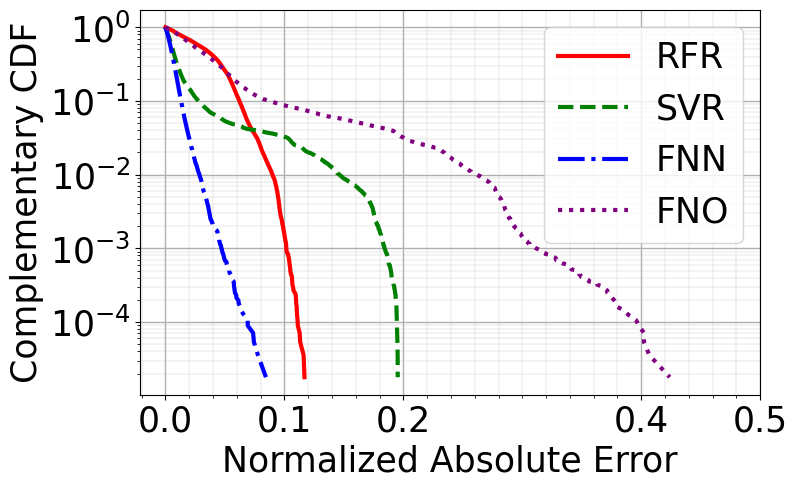

In [9]:
rfr_err_test = absolute_perctentage_error(d[:,-1], y_pred_t_rfr)
rfr_err_test = rfr_err_test.reshape(-1)

svr_err_test = absolute_perctentage_error(d[:,-1], y_pred_t_svr)
svr_err_test = svr_err_test.reshape(-1)

nn_err_test = absolute_perctentage_error(d[:,-1], y_pred_t_nn)
nn_err_test = nn_err_test.reshape(-1)

fno_err_test = absolute_perctentage_error(d[:,-1], y_pred_t_fno[:,:].reshape(-1))
fno_err_test = fno_err_test.reshape(-1)

plt.rcParams["figure.figsize"] = (8,5)

x = np.sort(rfr_err_test) 
y = np.arange(len(rfr_err_test)) / float(len(rfr_err_test)) 
plt.plot(x,1-y, color='red', label="RFR", linewidth=3, linestyle="solid")

x = np.sort(svr_err_test) 
y = np.arange(len(svr_err_test)) / float(len(svr_err_test)) 
plt.plot(x,1-y, color='green', label="SVR", linewidth=3, linestyle="--")

x = np.sort(nn_err_test) 
y = np.arange(len(nn_err_test)) / float(len(nn_err_test)) 
plt.plot(x,1-y, color='blue', label="FNN", linewidth=3, linestyle="-.")

x = np.sort(fno_err_test) 
y = np.arange(len(fno_err_test)) / float(len(fno_err_test)) 
plt.plot(x,1-y, color='purple', label="FNO", linewidth=3, linestyle=":")

plt.grid(which = "major", linewidth = 1)
plt.grid(which = "minor", linewidth = 0.2)
plt.minorticks_on()
plt.xlabel("Normalized Absolute Error", fontsize=25)
plt.ylabel("Complementary CDF", fontsize=25)
plt.semilogy()
plt.xticks([0, 0.1, 0.2, 0.4, 0.5], fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.show()

# CORNER_CRACK_BH_THROUGH_THICKNESS_TEST.csv

In [10]:
csv_file = "CORNER_CRACK_BH_THROUGH_THICKNESS_TEST.csv"

In [11]:
df = pd.read_csv("files/data/SINGLE_CRACK/CORNER_CRACK_STRAIGHT_HOLE/{}".format(csv_file))
df = df.drop(columns=['b/t'])
# df = df[(df["W/R"] >= 2) & (df["W/R"] <= 20)]
df = df[(df["r/t"] >= 0.5) & (df["r/t"] <= 1.5)]
df

,c_index,W/R,a/c,a/t,r/t,phi,K-T,K-B,K-P
0,1.0,200.000,0.1,1.15,0.50,0.050077,8.938764,5.602247,14.664594
1,1.0,200.000,0.1,1.15,0.50,0.057591,8.995716,5.614350,9.698707
2,1.0,200.000,0.1,1.15,0.50,0.065104,9.069096,5.634621,9.903749
3,1.0,200.000,0.1,1.15,0.50,0.072618,9.157998,5.662964,14.675771
4,1.0,200.000,0.1,1.15,0.50,0.080131,9.259129,5.697964,12.532271
...,...,...,...,...,...,...,...,...,...
153979,5417.0,133.333,10.0,1.75,0.75,0.548598,6.213748,-3.418036,190.092233
153980,5417.0,133.333,10.0,1.75,0.75,0.552706,6.207076,-3.464890,189.664216
153981,5417.0,133.333,10.0,1.75,0.75,0.556815,6.199627,-3.511807,189.249271
153982,5417.0,133.333,10.0,1.75,0.75,0.560924,6.191451,-3.558536,188.817020


In [12]:
# Get unique combinations of the first four columns
test_combinations = df.iloc[:, 1:5].drop_duplicates().to_numpy()

print(len(test_combinations))

print("Different W/R values: ", np.unique(test_combinations[:,0], axis=0))
print("Different a/c values: ", np.unique(test_combinations[:,1], axis=0))
print("Different a/t values: ", np.unique(test_combinations[:,2], axis=0))
print("Different r/t values: ", np.unique(test_combinations[:,3], axis=0))

356
Different W/R values:  [ 75.019  80.    125.    133.333 175.009 200.   ]
Different a/c values:  [ 0.1     0.111   0.125   0.1428  0.1667  0.2     0.25    0.333   0.5
  0.667   0.75    0.8     1.      1.25    1.333   1.5     2.      3.
  4.      5.      6.      7.      8.      9.     10.    ]
Different a/t values:  [1.05 1.15 1.25 1.5  1.75 2.   2.5  3.   4.   5.   6.   8.  ]
Different r/t values:  [0.5    0.5714 0.75   0.8    1.25   1.333 ]


## Preds

In [13]:
name = "CORNER_CRACK_BH_THROUGH_THICKNESS"

In [14]:
y_pred_t_rfr = np.load("files/predictions/rfr/{}_TENSION.npy".format(name))
y_pred_b_rfr = np.load("files/predictions/rfr/{}_BENDING.npy".format(name))
y_pred_p_rfr = np.load("files/predictions/rfr/{}_BEARING.npy".format(name))

y_pred_t_svr = np.load("files/predictions/svr/{}_TENSION.npy".format(name))
y_pred_b_svr = np.load("files/predictions/svr/{}_BENDING.npy".format(name))
y_pred_p_svr = np.load("files/predictions/svr/{}_BEARING.npy".format(name))

y_pred_t_nn = np.load("files/predictions/nn/{}_TENSION.npy".format(name))
y_pred_b_nn = np.load("files/predictions/nn/{}_BENDING.npy".format(name))
y_pred_p_nn = np.load("files/predictions/nn/{}_BEARING.npy".format(name))

y_pred_t_fno = np.load("files/predictions/fno/{}_TENSION.npy".format(name))
y_pred_b_fno = np.load("files/predictions/fno/{}_BENDING.npy".format(name))
y_pred_p_fno = np.load("files/predictions/fno/{}_BEARING.npy".format(name))

## Plots

In [15]:
d = df.to_numpy()[::8,1:]
d.shape

(5696, 8)

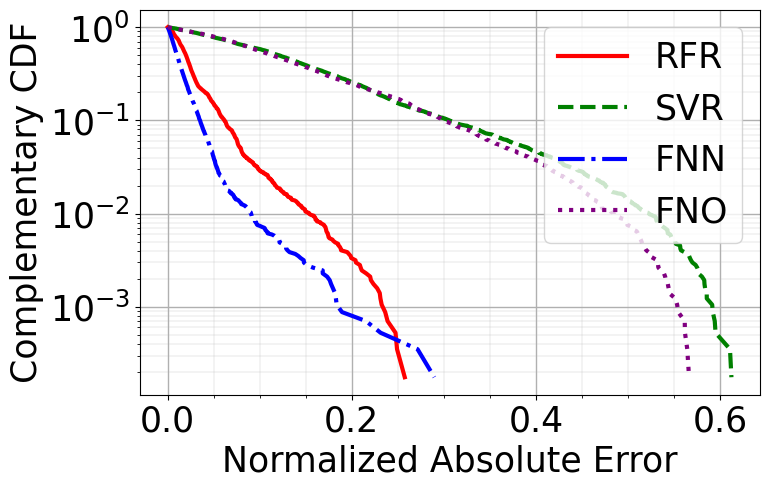

In [16]:
rfr_err_test = absolute_perctentage_error(d[:,-3], y_pred_t_rfr)
rfr_err_test = rfr_err_test.reshape(-1)

svr_err_test = absolute_perctentage_error(d[:,-3], y_pred_t_svr)
svr_err_test = svr_err_test.reshape(-1)

nn_err_test = absolute_perctentage_error(d[:,-3], y_pred_t_nn)
nn_err_test = nn_err_test.reshape(-1)

fno_err_test = absolute_perctentage_error(d[:,-3], y_pred_t_fno[:,::8].reshape(-1))
fno_err_test = fno_err_test.reshape(-1)

plt.rcParams["figure.figsize"] = (8,5)

x = np.sort(rfr_err_test) 
y = np.arange(len(rfr_err_test)) / float(len(rfr_err_test)) 
plt.plot(x,1-y, color='red', label="RFR", linewidth=3, linestyle="solid")

x = np.sort(svr_err_test) 
y = np.arange(len(svr_err_test)) / float(len(svr_err_test)) 
plt.plot(x,1-y, color='green', label="SVR", linewidth=3, linestyle="--")

x = np.sort(nn_err_test) 
y = np.arange(len(nn_err_test)) / float(len(nn_err_test)) 
plt.plot(x,1-y, color='blue', label="FNN", linewidth=3, linestyle="-.")

x = np.sort(fno_err_test) 
y = np.arange(len(fno_err_test)) / float(len(fno_err_test)) 
plt.plot(x,1-y, color='purple', label="FNO", linewidth=3, linestyle=":")

plt.grid(which = "major", linewidth = 1)
plt.grid(which = "minor", linewidth = 0.2)
plt.minorticks_on()
plt.xlabel("Normalized Absolute Error", fontsize=25)
plt.ylabel("Complementary CDF", fontsize=25)
plt.semilogy()
plt.xticks([0, 0.2, 0.4, 0.6], fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25, loc='upper right')
plt.show()